# Imports

In [248]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os
from keras.utils import image_dataset_from_directory
from dotenv import load_dotenv
load_dotenv()


True

In [249]:
emotion_detection_dir = os.getenv("EMOTION_DETECTION_DATASETS_DIR")
train_dir = emotion_detection_dir + "/train"
test_dir = emotion_detection_dir + "/test"

CLASS_LABELS = os.listdir(train_dir)
EPOCHS = 15
BATCH_SIZE = 64
IMG_HEIGHT = 48
IMG_WIDTH  = 48
SEED = 2137

In [250]:
train_ds = image_dataset_from_directory(directory=train_dir, 
                                       labels="inferred",
                                       label_mode="int",
                                       color_mode="grayscale",
                                       batch_size=BATCH_SIZE,
                                       image_size=(IMG_HEIGHT, IMG_WIDTH),
                                       seed=SEED,
                                       verbose=True)
val_ds = image_dataset_from_directory(directory=test_dir, 
                                       labels="inferred",
                                       label_mode="int",
                                       color_mode="grayscale",
                                       batch_size=BATCH_SIZE,
                                       image_size=(IMG_HEIGHT, IMG_WIDTH),
                                       seed=SEED,
                                       verbose=True)

Found 28709 files belonging to 7 classes.
Found 7178 files belonging to 7 classes.


In [251]:
class_names = train_ds.class_names
print(class_names)

['angry', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised']


In [252]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(64, 48, 48, 1)
(64,)


# Sample Images

2024-05-05 03:50:33.619302: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


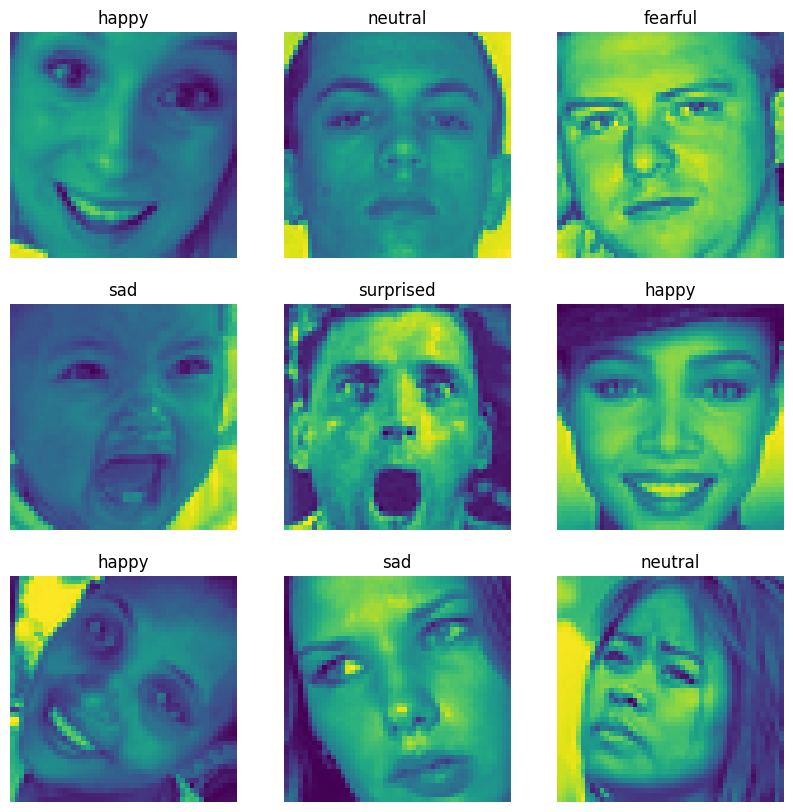

In [253]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.title(class_names[labels[i]])
    plt.axis("off")


# Exploring number of images in each class

In [254]:
def count_classes(dataset):
    """ Count the occurrences of each class in the dataset. """
    label_counts = {}
    for images, labels in dataset:
        for label in labels:
            label = int(label.numpy())
            if label in label_counts:
                label_counts[label] += 1
            else:
                label_counts[label] = 1
    return label_counts

# Function to plot a pie chart of class distribution
def plot_class_distribution(label_counts, class_names):
    """ Plot a pie chart of the class distribution. """
    sizes = [label_counts.get(i, 0) for i in range(len(class_names))]
    plt.figure(figsize=(10, 8))
    plt.pie(sizes, labels=class_names, autopct='%1.1f%%', startangle=90)
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.title('Class Distribution in Dataset')
    plt.show()


2024-05-05 03:50:38.245511: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


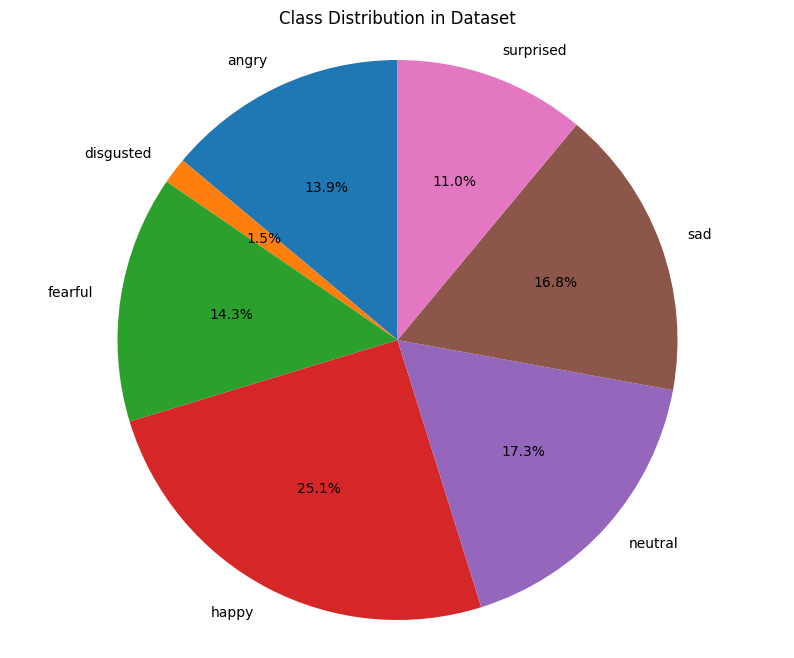

2024-05-05 03:50:39.486546: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


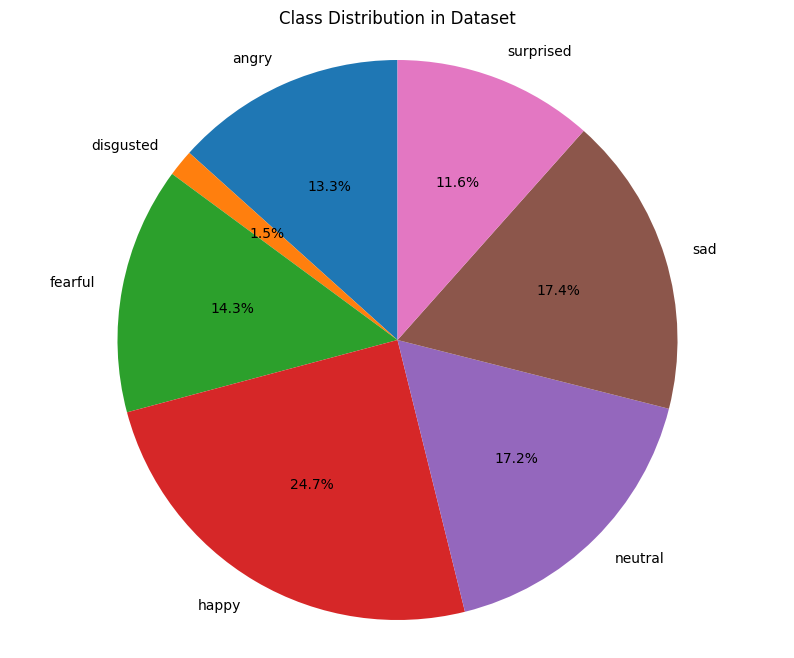

In [255]:
label_counts = count_classes(train_ds)
plot_class_distribution(label_counts, train_ds.class_names)
label_counts = count_classes(val_ds)
plot_class_distribution(label_counts, val_ds.class_names)

# CNN Model

In [256]:
ED_model = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255, input_shape=(IMG_HEIGHT, IMG_WIDTH, 1)),
    tf.keras.layers.Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(rate=0.3),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(rate=0.3),
    tf.keras.layers.Dense(len(class_names), activation='softmax')
])
ED_model.summary()


/Users/31_grudnia/Desktop/Python/Playground/Masters_Degree_Project/backend/venv/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:18: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_31 (Rescaling)        │ (None, 48, 48, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_64 (Conv2D)              │ (None, 48, 48, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_64 (MaxPooling2D) │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_65 (Conv2D)              │ (None, 24, 24, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_65 (MaxPooling2D) │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_66 (Conv2D)              │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_66 (MaxPooling2D) │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_67 (Conv2D)              │ (None, 6, 6, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_67 (MaxPooling2D) │ (None, 3, 3, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_16 (Flatten)            │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 256)            │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,011,719 (3.86 MB)

 Trainable params: 1,011,719 (3.86 MB)

 Non-trainable params: 0 (0.00 B)

In [257]:
ED_model.compile(optimizer='adam',
                 loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                 metrics=['accuracy'])

In [258]:
history = ED_model.fit(
    x=train_ds,
    validation_data=val_ds,
    epochs=EPOCHS
)

Epoch 1/15
449/449 ━━━━━━━━━━━━━━━━━━━━ 86s 188ms/step - accuracy: 0.2411 - loss: 1.8310 - val_accuracy: 0.2881 - val_loss: 1.7344
Epoch 2/15
449/449 ━━━━━━━━━━━━━━━━━━━━ 75s 168ms/step - accuracy: 0.3379 - loss: 1.6509 - val_accuracy: 0.4299 - val_loss: 1.4520
Epoch 3/15
449/449 ━━━━━━━━━━━━━━━━━━━━ 79s 176ms/step - accuracy: 0.4481 - loss: 1.4253 - val_accuracy: 0.4889 - val_loss: 1.3394
Epoch 4/15
449/449 ━━━━━━━━━━━━━━━━━━━━ 76s 169ms/step - accuracy: 0.4983 - loss: 1.3050 - val_accuracy: 0.5166 - val_loss: 1.2676
Epoch 5/15
449/449 ━━━━━━━━━━━━━━━━━━━━ 76s 169ms/step - accuracy: 0.5409 - loss: 1.2115 - val_accuracy: 0.5157 - val_loss: 1.2334
Epoch 6/15
449/449 ━━━━━━━━━━━━━━━━━━━━ 82s 182ms/step - accuracy: 0.5736 - loss: 1.1277 - val_accuracy: 0.5339 - val_loss: 1.2256
Epoch 7/15
449/449 ━━━━━━━━━━━━━━━━━━━━ 67s 149ms/step - accuracy: 0.6050 - loss: 1.0512 - val_accuracy: 0.5401 - val_loss: 1.2332
Epoch 8/15
449/449 ━━━━━━━━━━━━━━━━━━━━ 71s 157ms/step - accuracy: 0.6354 - loss: 0

In [259]:
machine_learning_models_dir = os.getenv("MACHINE_LEARNING_MODELS_FOLDER_PATH") 
save_path = machine_learning_models_dir + "/ED_with_tensorflow.keras"
ED_model.save(filepath=save_path)

# Metrics


In [261]:
print(history.history.keys())

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


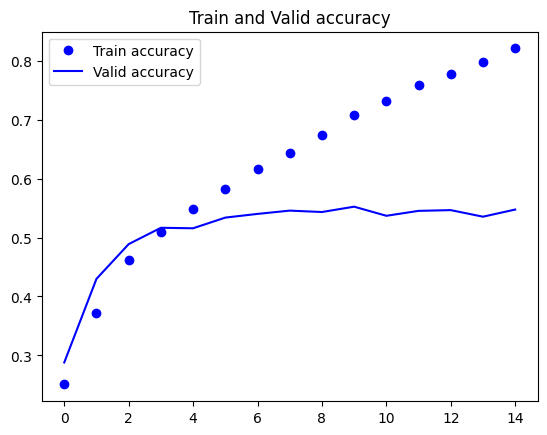

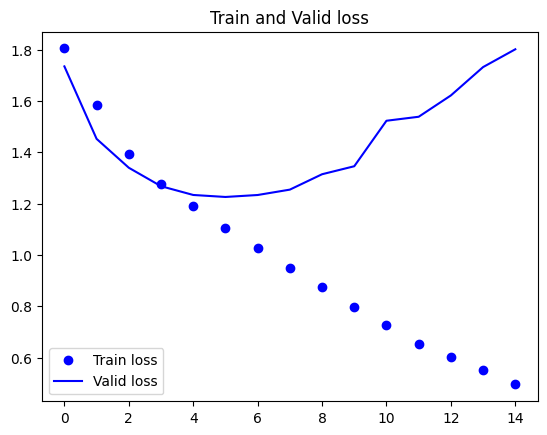

In [262]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.figure()
plt.plot(epochs, acc, 'bo', label='Train accuracy')
plt.plot(epochs, val_acc, 'b', label='Valid accuracy')
plt.title('Train and Valid accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'bo', label='Train loss') 
plt.plot(epochs, val_loss, 'b', label='Valid loss') 
plt.title('Train and Valid loss')
plt.legend()
plt.show()